# Bank Institution Term Deposit Predictive Model
#### Business Need Case Study
The investment and portfolio department would want to be able to identify their customers who potentially would subscribe to their term deposits. As there has been heightened interest of marketing managers to carefully tune their directed campaigns to the rigorous selection of contacts, the goal of your employer is to find a model that can predict which future clients who would subscribe to their term deposit. Having such an effective predictive model can help increase their campaign efficiency as they would be able to identify customers who would subscribe to their term deposit and thereby direct their marketing efforts to them. This would help them better manage their resources (e.g human effort, phone calls, time)
The Bank of Portugal, therefore, collected a huge amount of data that includes customers profiles of those who have to subscribe to term deposits and the ones who did not subscribe to a term deposit. As their newly employed machine learning researcher, they want you to come up with a robust predictive model that would help them identify customers who would or would not subscribe to their term deposit in the future.
Your main goal as a machine learning researcher is to carry out data exploration, data cleaning, feature extraction, and developing robust machine learning algorithms that would aid them in the department.


In [1]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.linear_model as lm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import accuracy_score,confusion_matrix,roc_curve, \
                                    auc, f1_score, precision_score, recall_score

# used for Oversampling and undersampling imbalanced data
from sklearn.svm import SVC
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler


# libraries used for Multilayer perception model both KFold and Stratified KFold
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier

### Dataset 
The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) was subscribed or not. Data set has 21 predictor varaibles (features) and around 41K rows. 

Top 5 rows of the dataset is shown below.

In [2]:
# loading Dataset given for this case study
data_bank = pd.read_csv( "data/bank-additional-full.csv", sep=";")

data_bank.head(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Customers who received phone calls may not be unique and a same customer might have received multiple calls. The last column in the dataset 'y' is our response. This report tries to get the best model to predict the subscription of term deposit.

### Explotrary Data analysis

In [3]:
## categorizing columns as categorical and numerical

In [4]:
def cat_num_categorize(df):
    numerical = list()
    categorical= list()
    for column in df.columns:
       
        if df[column].dtype is np.dtype( 'O'):
            categorical.append(column)
        else:
            numerical.append(column)
    return numerical, categorical


In [5]:
numerical , categorical = cat_num_categorize(data_bank)
print("Numerical Columns list: ", numerical)
print()
print("Categorical Columns List: ", categorical)

Numerical Columns list:  ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

Categorical Columns List:  ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y']


In [6]:
# lets see the information with the calculation available on numerical columns
data_bank[numerical].describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [7]:
# lets see the information with the calculation available on categorical columns
data_bank[categorical].value_counts()

job         marital  education          default  housing  loan  contact   month  day_of_week  poutcome     y  
admin.      single   university.degree  no       yes      no    cellular  aug    thu          nonexistent  no     60
            married  university.degree  no       yes      no    cellular  aug    wed          nonexistent  no     55
                                                                                 thu          nonexistent  no     51
                                                                                 tue          nonexistent  no     49
                                                 no       no    cellular  aug    thu          nonexistent  no     45
                                                                                                                  ..
retired     married  unknown            no       yes      no    cellular  may    thu          success      no      1
                                                                      

#### Exploratory data analysis

In [8]:
## Graphical analysis
# let's divide our data into two to see the ourcome from the given data
data1 = data_bank[data_bank['y'] == 'yes']
data2 = data_bank[data_bank['y'] == 'no']

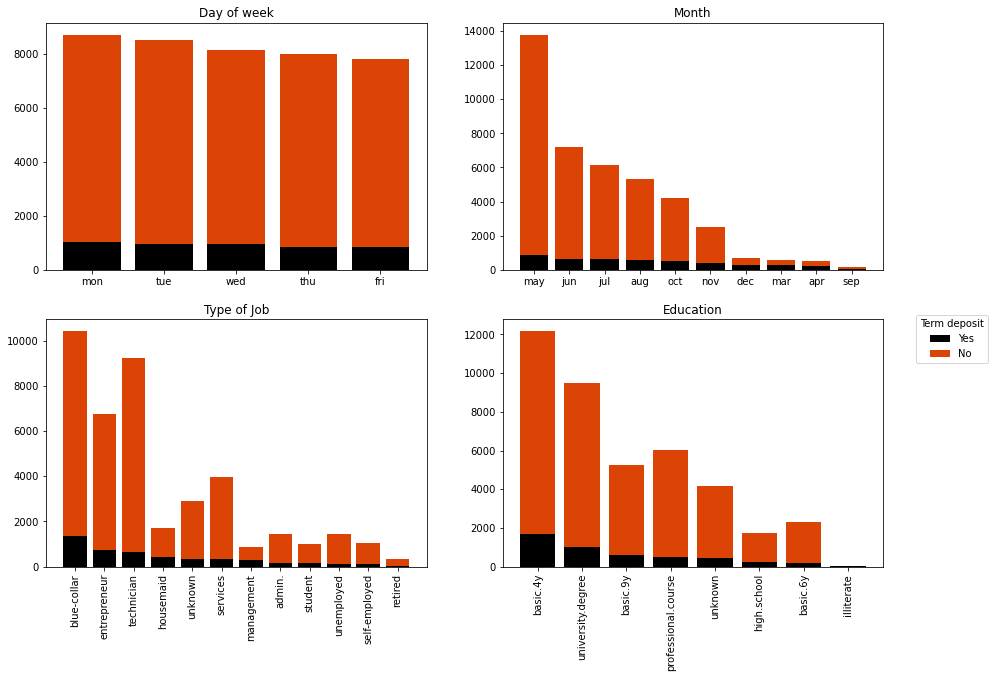

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(15,10))

b1 = ax[0, 0].bar(data1['day_of_week'].unique(),height = data1['day_of_week'].
                  value_counts(),color='#000000')
b2 = ax[0, 0].bar(data2['day_of_week'].unique(),height = data2['day_of_week'].
                  value_counts(),bottom = data1['day_of_week'].
                  value_counts(),color = '#DC4405') 
ax[0, 0].title.set_text('Day of week')
#ax[0, 0].legend((b1[0], b2[0]), ('Yes', 'No'))
ax[0, 1].bar(data1['month'].unique(),height = data1['month'].
             value_counts(),color='#000000')
ax[0, 1].bar(data2['month'].unique(),height = data2['month'].
             value_counts(),bottom = data1['month'].value_counts(),color = '#DC4405') 
ax[0, 1].title.set_text('Month')
ax[1, 0].bar(data1['job'].unique(),height = data1['job'].
             value_counts(),color='#000000')
ax[1, 0].bar(data1['job'].unique(),height = data2['job'].
             value_counts()[data1['job'].value_counts().index],bottom = data1['job'].
             value_counts(),color = '#DC4405') 
ax[1, 0].title.set_text('Type of Job')
ax[1, 0].tick_params(axis='x',rotation=90)
ax[1, 1].bar(data1['education'].unique(),height = data1['education'].
             value_counts(),color='#000000') #row=0, col=1
ax[1, 1].bar(data1['education'].unique(),height = data2['education'].
             value_counts()[data1['education'].value_counts().index],bottom = data1['education'].
             value_counts(),color = '#DC4405') 
ax[1, 1].title.set_text('Education')
ax[1, 1].tick_params(axis='x',rotation=90)
#ax[0, 1].xticks(rotation=90)
plt.figlegend((b1[0], b2[0]), ('Yes', 'No'),loc="right",title = "Term deposit")
plt.show()

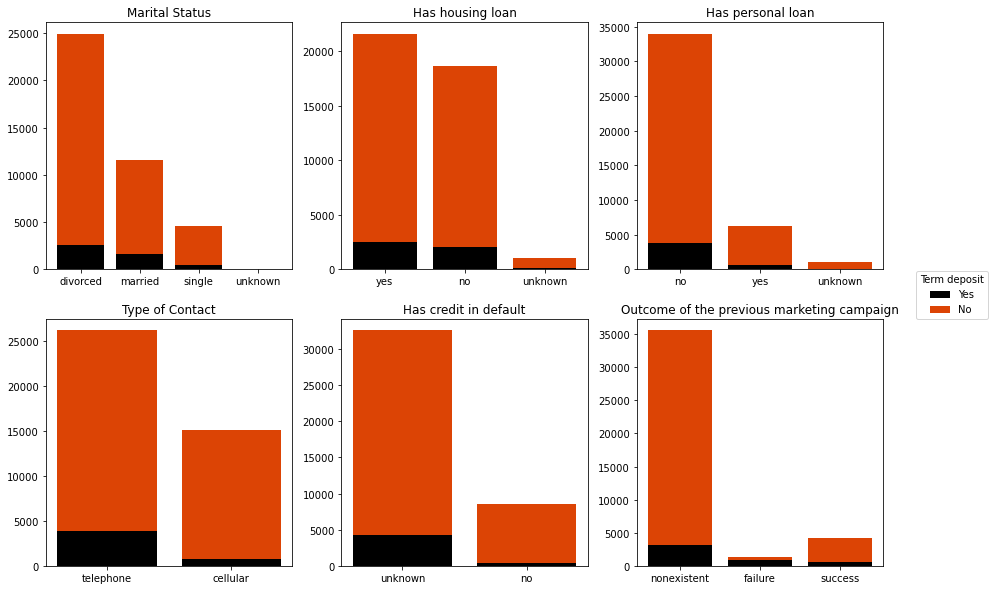

In [10]:
fig, ax = plt.subplots(2, 3, figsize=(15,10))

b1 = ax[0, 0].bar(data1['marital'].unique(),height = data1['marital'].value_counts(),color='#000000')
b2 = ax[0, 0].bar(data1['marital'].unique(),height = data2['marital'].value_counts()[data1['marital'].value_counts().index],bottom = data1['marital'].value_counts(),color = '#DC4405') 
ax[0, 0].title.set_text('Marital Status')
#ax[0, 0].legend((b1[0], b2[0]), ('Yes', 'No'))
ax[0, 1].bar(data1['housing'].unique(),height = data1['housing'].value_counts(),color='#000000')
ax[0, 1].bar(data1['housing'].unique(),height = data2['housing'].value_counts()[data1['housing'].value_counts().index],bottom = data1['housing'].value_counts(),color = '#DC4405') 
ax[0, 1].title.set_text('Has housing loan')
ax[0, 2].bar(data1['loan'].unique(),height = data1['loan'].value_counts(),color='#000000')
ax[0, 2].bar(data1['loan'].unique(),height = data2['loan'].value_counts()[data1['loan'].value_counts().index],bottom = data1['loan'].value_counts(),color = '#DC4405') 
ax[0, 2].title.set_text('Has personal loan')
ax[1, 0].bar(data1['contact'].unique(),height = data1['contact'].value_counts(),color='#000000')
ax[1, 0].bar(data1['contact'].unique(),height = data2['contact'].value_counts()[data1['contact'].value_counts().index],bottom = data1['contact'].value_counts(),color = '#DC4405') 
ax[1, 0].title.set_text('Type of Contact')
ax[1, 1].bar(data1['default'].unique(),height = data1['default'].value_counts(),color='#000000')
ax[1, 1].bar(data1['default'].unique(),height = data2['default'].value_counts()[data1['default'].value_counts().index],bottom = data1['default'].value_counts(),color = '#DC4405') 
ax[1, 1].title.set_text('Has credit in default')
ax[1, 2].bar(data1['poutcome'].unique(),height = data1['poutcome'].value_counts(),color='#000000')
ax[1, 2].bar(data1['poutcome'].unique(),height = data2['poutcome'].value_counts()[data1['poutcome'].value_counts().index],bottom = data1['poutcome'].value_counts(),color = '#DC4405') 
ax[1, 2].title.set_text('Outcome of the previous marketing campaign')
plt.figlegend((b1[0], b2[0]), ('Yes', 'No'),loc="right",title = "Term deposit")
plt.show()

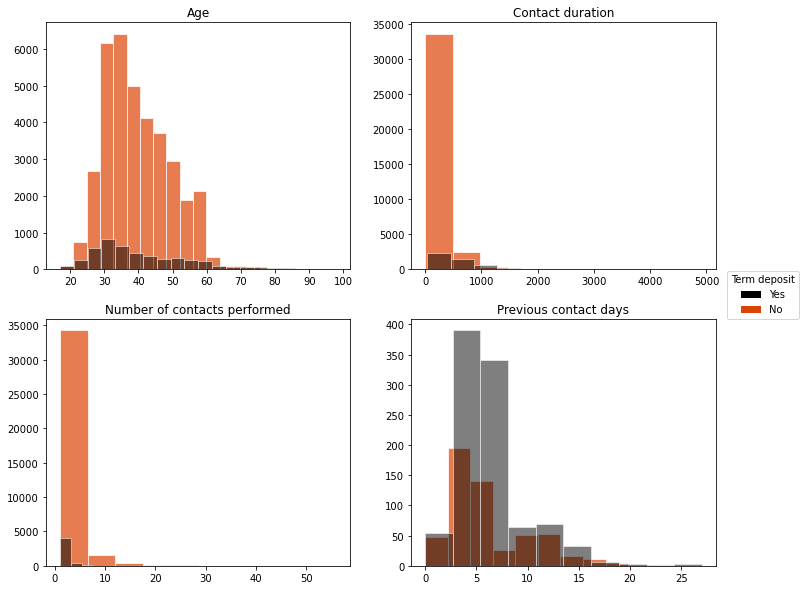

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(12,10))

ax[0, 0].hist(data2['age'],color = '#DC4405',alpha=0.7,bins=20, edgecolor='white') 
ax[0, 0].hist(data1['age'],color='#000000',alpha=0.5,bins=20, edgecolor='white')
ax[0, 0].title.set_text('Age')
ax[0, 1].hist(data2['duration'],color = '#DC4405',alpha=0.7, edgecolor='white') 
ax[0, 1].hist(data1['duration'],color='#000000',alpha=0.5, edgecolor='white')
ax[0, 1].title.set_text('Contact duration')
ax[1, 0].hist(data2['campaign'],color = '#DC4405',alpha=0.7, edgecolor='white') 
ax[1, 0].hist(data1['campaign'],color='#000000',alpha=0.5, edgecolor='white')
ax[1, 0].title.set_text('Number of contacts performed')
ax[1, 1].hist(data2[data2['pdays'] != 999]['pdays'],color = '#DC4405',alpha=0.7, edgecolor='white') 
ax[1, 1].hist(data1[data1['pdays'] != 999]['pdays'],color='#000000',alpha=0.5, edgecolor='white')
ax[1, 1].title.set_text('Previous contact days')
plt.figlegend((b1[0], b2[0]), ('Yes', 'No'),loc="right",title = "Term deposit")
plt.show()

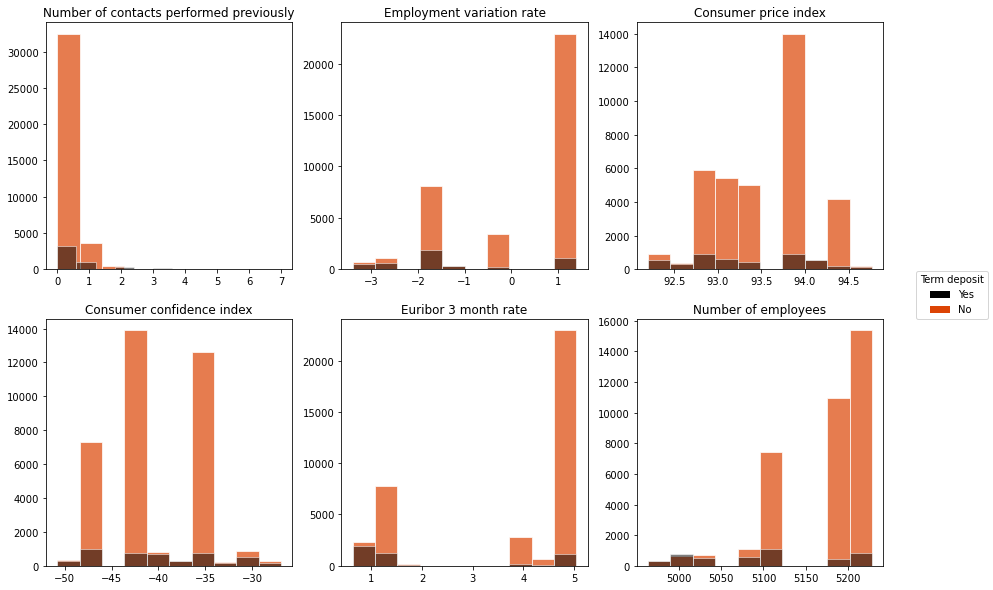

In [12]:
fig, ax = plt.subplots(2, 3, figsize=(15,10))
ax[0, 0].hist(data2['previous'],color = '#DC4405',alpha=0.7, edgecolor='white') 
ax[0, 0].hist(data1['previous'],color='#000000',alpha=0.5, edgecolor='white')
ax[0, 0].title.set_text('Number of contacts performed previously')
ax[0, 1].hist(data2['emp.var.rate'],color = '#DC4405',alpha=0.7, edgecolor='white') 
ax[0, 1].hist(data1['emp.var.rate'],color='#000000',alpha=0.5, edgecolor='white')
ax[0, 1].title.set_text('Employment variation rate')
ax[0, 2].hist(data2['cons.price.idx'],color = '#DC4405',alpha=0.7, edgecolor='white') 
ax[0, 2].hist(data1['cons.price.idx'],color='#000000',alpha=0.5, edgecolor='white')
ax[0, 2].title.set_text('Consumer price index')
ax[1, 0].hist(data2['cons.conf.idx'],color = '#DC4405',alpha=0.7, edgecolor='white') 
ax[1, 0].hist(data1['cons.conf.idx'],color='#000000',alpha=0.5, edgecolor='white')
ax[1, 0].title.set_text('Consumer confidence index')
ax[1, 1].hist(data2['euribor3m'],color = '#DC4405',alpha=0.7, edgecolor='white') 
ax[1, 1].hist(data1['euribor3m'],color='#000000',alpha=0.5, edgecolor='white')
ax[1, 1].title.set_text('Euribor 3 month rate')
ax[1, 2].hist(data2['nr.employed'],color = '#DC4405',alpha=0.7, edgecolor='white') 
ax[1, 2].hist(data1['nr.employed'],color='#000000',alpha=0.5, edgecolor='white')
ax[1, 2].title.set_text('Number of employees')
plt.figlegend((b1[0], b2[0]), ('Yes', 'No'),loc="right",title = "Term deposit")
plt.show()

All the histograms show similar behavior (proportion of 'no' is higher than 'yes') except 'Previous contact days'. Proportion of 'yes' is higher compared to 'no' (only if contacted more than once).

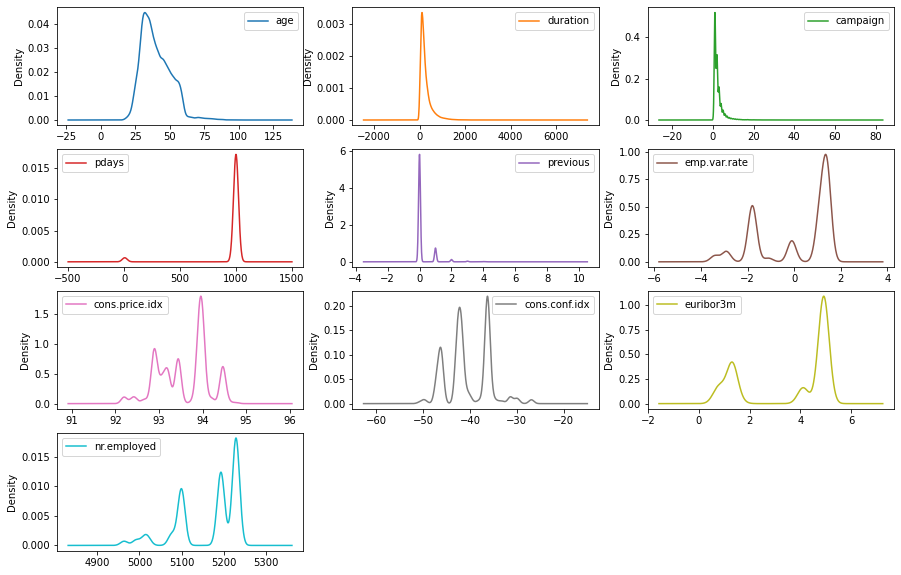

In [13]:
#plot histogram of all numerical data
def plot_density_numerical(df):
    df.plot(kind='density', subplots=True, layout=(4,3), sharex=False,figsize=(15,10))
    plt.show()
plot_density_numerical(data_bank[numerical])

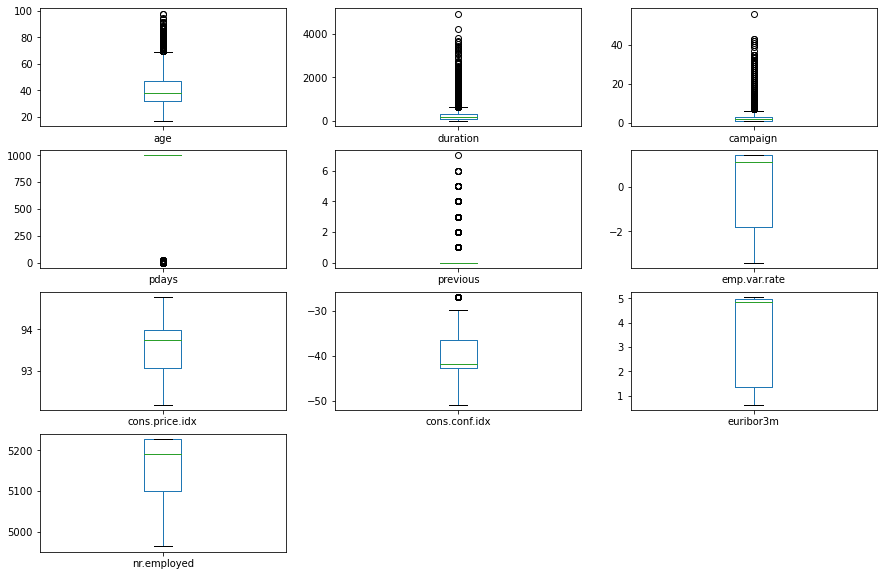

In [14]:
# Lets check for outliers inside our data if we have any using box plot on numerical data
def plot_box_numerical(df):
    df.plot(kind='box', subplots=True, layout=(4,3), sharex=False,figsize=(15,10))
    plt.show()
plot_box_numerical(data_bank[numerical])


**Note:** as we can see from the plot there are huge outliers in columns such as pdays, previous, campaign,duration.

In [15]:
#Lets handle outliers by imputing either max, median and mean where we have outliers
#replacing duration outliers with mean value
mean = data_bank['duration'].mean()
data_bank['duration'] = np.where(data_bank.duration > 645,mean,data_bank['duration'])

#replacing campaign outliers with mean value
mean = data_bank['campaign'].mean()
data_bank['campaign'] = np.where(data_bank.campaign > 7, mean,data_bank['campaign'])

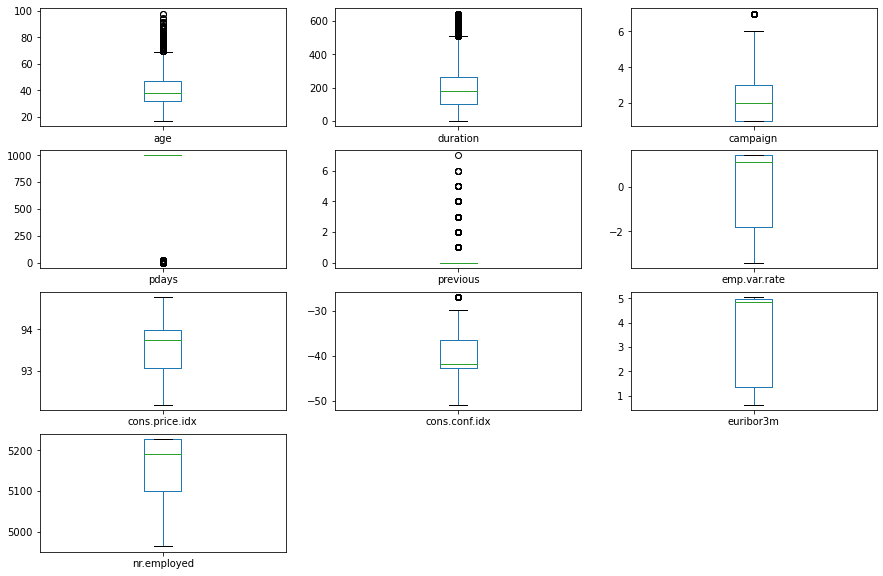

In [16]:
#checking after removal of ouliers
plot_box_numerical(data_bank[numerical])

## Classification Model for Predicting Term Deposit


#### lets break down this section and do devide and conquere
* Preprocessing 
* Train, Test Split 
* Select Machine Learning Models 


### preprocessing

In [17]:
## Lets handle the invalid data by droping them
def drop_unknown_rows(df, cat_cols):
    for column in cat_cols:
        df = df[df[column] != 'unknown']
    return df
        

In [18]:
#lets use the helper function to do the dropping of the unknown value
data_bank = drop_unknown_rows(data_bank, categorical)

In [19]:
#as we see from the box plot we don't want use pdays so lets drop it
predictors = data_bank.iloc[:,0:20]
predictors = predictors.drop(['pdays'],axis=1)
y = data_bank.iloc[:,20]
X = pd.get_dummies(predictors)

In [20]:
# Handling the datasets variable
level_mapping = {'illiterate': 0, 'basic.4y': 1, 'basic.6y': 2,
                 'basic.9y':3, 'high.school':4,'professional.course':5,
                 'university.degree': 6}
data_bank['education'] = data_bank['education'].replace(level_mapping)

In [21]:
# encoding the binary features
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
binary_cols = ['default','housing','loan','contact','y']
data_bank[binary_cols] = data_bank[binary_cols].apply(lambda col: encoder.fit_transform(col))


get_dummies() function
The get_dummies() function is used to convert categorical variable into dummy/indicator variables.

In [22]:
# transforming categorical colums into dumy variables
data_bank = pd.get_dummies(data_bank, columns=['job','marital','month','day_of_week','poutcome'],
                                     drop_first=True)

Given data set is highly imbalanced, i.e. number of data belonging to 'no' category is way higher than 'yes' category.

In [23]:
y.value_counts()

no     26629
yes     3859
Name: y, dtype: int64

This imbalance has to treated so as to make sure that there is no bias in modeling. Imbalance is generally treated in three ways.

Text(0.5, 1.0, 'Correlation Matrix')

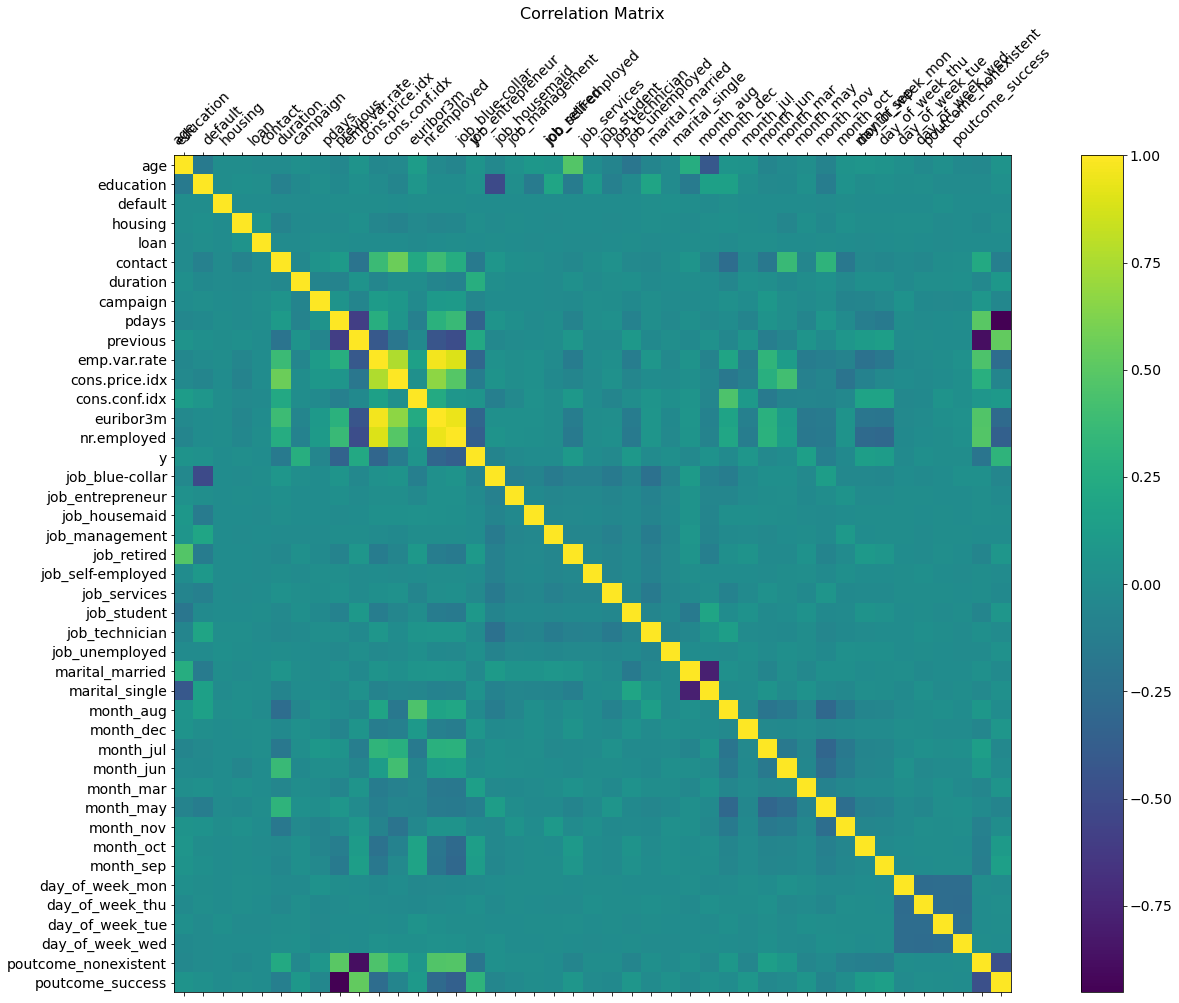

In [24]:
# correlation matrix from the bank
cor = data_bank.corr()
f = plt.figure(figsize=(25, 15))
plt.matshow(cor, fignum=f.number)
plt.xticks(range(data_bank.shape[1]), data_bank.columns, fontsize=14, rotation=45)
plt.yticks(range(data_bank.shape[1]), data_bank.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

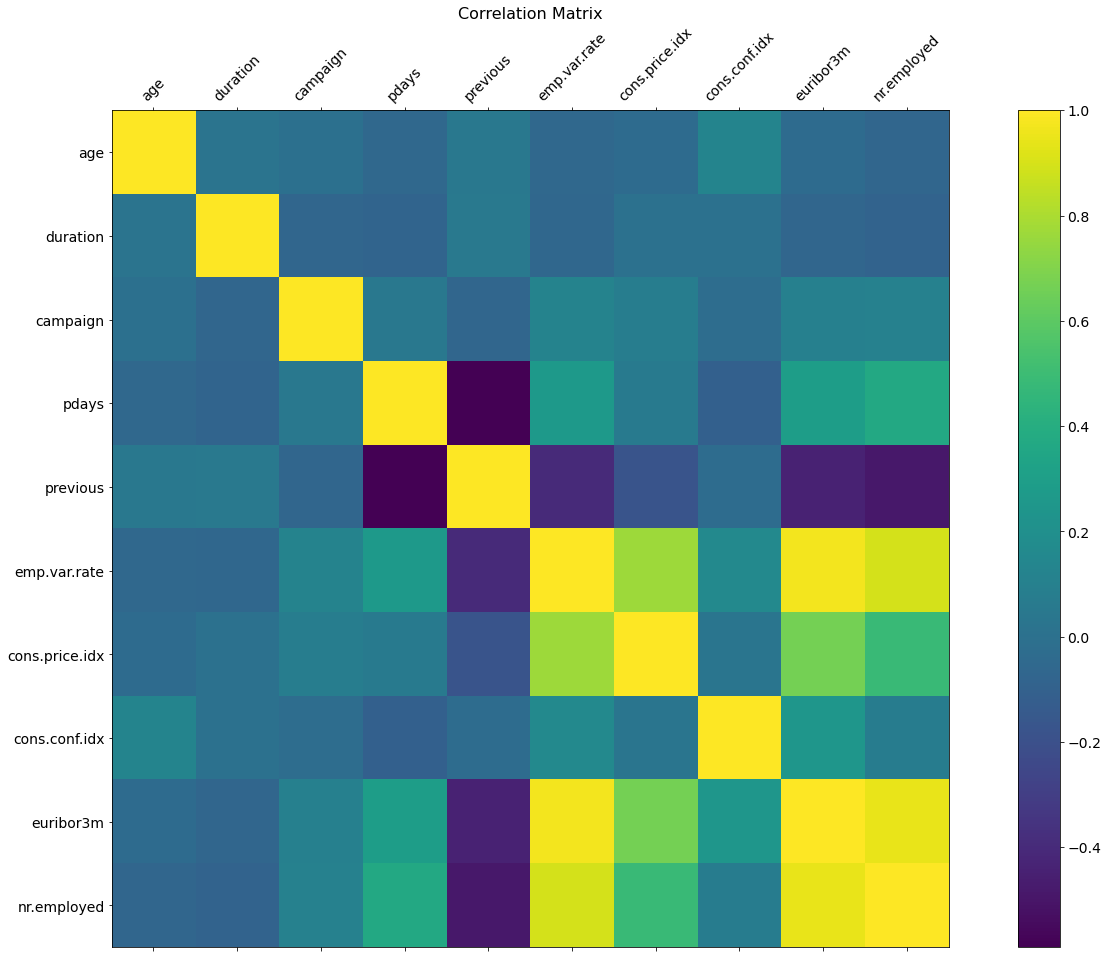

In [25]:
# correlation matrix for numerical columns from the dataset
cor = data_bank[numerical].corr()
f = plt.figure(figsize=(25, 15))
plt.matshow(cor, fignum=f.number)
plt.xticks(range(data_bank[numerical].shape[1]), data_bank[numerical].columns, fontsize=14, rotation=45)
plt.yticks(range(data_bank[numerical].shape[1]), data_bank[numerical].columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

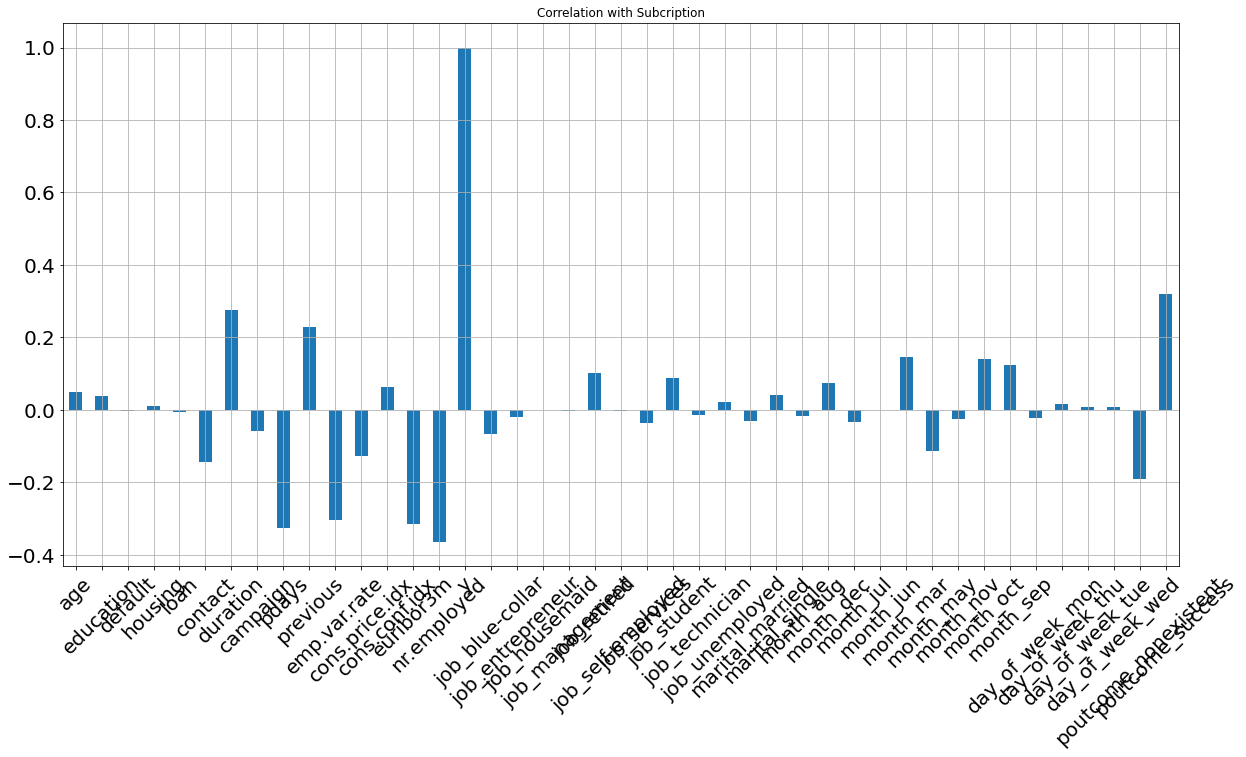

In [26]:
# lets compare the one on one correlation to have a clear visuals
data_bank.corrwith(data_bank.y).plot.bar(
        figsize = (20, 10), title = "Correlation with Subcription", fontsize = 20,
        rot = 45, grid = True)
plt.show()

/home/samuel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


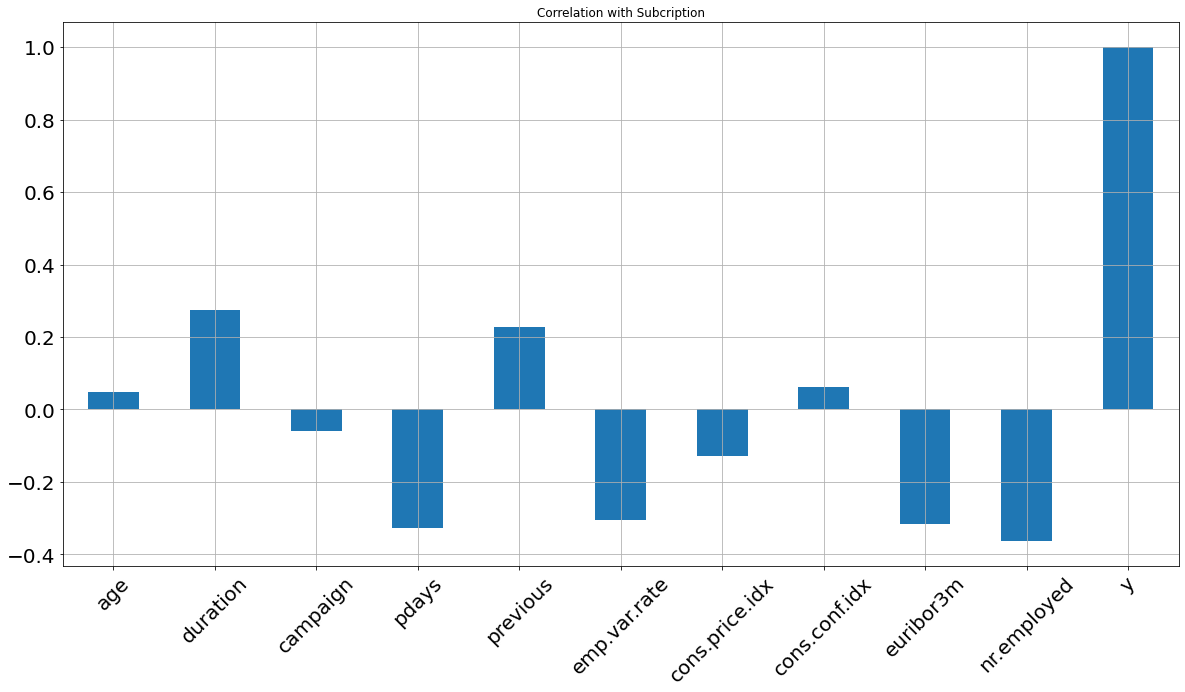

In [27]:
data_numerical = data_bank[numerical]
data_numerical['y'] = data_bank['y']
data_numerical.corrwith(data_numerical.y).plot.bar(
        figsize = (20, 10), title = "Correlation with Subcription", fontsize = 20,
        rot = 45, grid = True)
plt.show()

## Model Fitting

#### Perceptron

Simple linear classifier is fitted on the imbalanced data. Model is highly biased towards 'no' class. Accuracy is high for this model which is expected for imbalanced data.

### Random Undersampling
In this method, the majority category, in this case 'no' category is randomly sampled to match the size of the minority 'yes' category. Remaining data of majority category is discarded.

In [28]:
rus = RandomUnderSampler(random_state=0)
X_Usampled, y_Usampled = rus.fit_resample(X, y)
pd.Series(y_Usampled).value_counts()

yes    3859
no     3859
Name: y, dtype: int64

### Random Oversampling
In this method, the minority category 'no' is randomly sampled with replacement to match the size of the majority 'no' category. Minority category entries will be repeated many times.

In [36]:
ros = RandomOverSampler(random_state=0)
X_Osampled, y_Osampled = ros.fit_resample(X, y)
pd.Series(y_Osampled).value_counts()

yes    26629
no     26629
Name: y, dtype: int64

### SMOTE - Synthetic Minority Oversampling Technique
This is an oversampling technique in which instead of randomly repeating minority 'yes' category, new entires are sythetically created maintaining the convexity of minority entry space. Minority category will again match the majority category samples.

In [37]:
sm = SMOTE(random_state=0)
X_SMOTE, y_SMOTE = sm.fit_resample(X, y)
pd.Series(y_SMOTE).value_counts()

yes    26629
no     26629
Name: y, dtype: int64

**Note: These different imbalance treatements will be used in different data modeling techniques based on the need.**

In [42]:
#Train test splitting is happening here to 90% train and 10% test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)


In [43]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
perp_model = lm.Perceptron().fit(X_train_std,y_train)
y_pred = perp_model.predict(X_test_std)
print("Accuracy: ",round(accuracy_score(y_test, y_pred),2))

Accuracy:  0.85


Confusion matrix gives a better idea. Categorization of minority 'yes' class is far from perfect which is indicated by poor precision score and recall score.

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

mat = confusion_matrix(y_test,y_pred,labels=['no','yes'])
print(mat)
y_test = label_binarize(y_test,classes=['no','yes'])
y_pred = label_binarize(y_pred,classes=['no','yes'])
print("Precision: ",round(precision_score(y_test,y_pred),2),"Recall: ",round(recall_score(y_test,y_pred),2))

[[2351  307]
 [ 344   47]]
Precision:  0.13 Recall:  0.12


When percptron model is fit for SMOTE data, bias is shifted towards 'yes' class. This results in better recall score and worse precision score than before.

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
sm = SMOTE(random_state=0)
X_SMOTE, y_SMOTE = sm.fit_resample(X_train, y_train)
sc = StandardScaler()
sc.fit(X_SMOTE)
X_train_std = sc.transform(X_SMOTE)
X_test_std = sc.transform(X_test)
perp_model = lm.Perceptron().fit(X_train_std,y_SMOTE)
y_pred = perp_model.predict(X_test_std)
print("Accuracy: ",round(accuracy_score(y_test, y_pred),2))
mat = confusion_matrix(y_test,y_pred)
print("Confusion Matrix: \n",mat)
y_test = label_binarize(y_test,classes=['no','yes'])
y_pred = label_binarize(y_pred,classes=['no','yes'])
print("Precision: ",round(precision_score(y_test,y_pred),2),"Recall: ",round(recall_score(y_test,y_pred),2))

Accuracy:  0.81
Confusion Matrix: 
 [[2309  341]
 [ 247  152]]
Precision:  0.31 Recall:  0.38


 ### Decision Tree

Decision tree is another simple yet powerful classification tool. But this model faces the same problem of bad precision score and bad recall score for imbalanced data.

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
tree = DecisionTreeClassifier(criterion="entropy", max_depth=7)
model = tree.fit(X_train,y_train)
y_pred = model.predict(X_test)
y_test = label_binarize(y_test,classes=['no','yes'])
y_pred = label_binarize(y_pred,classes=['no','yes'])
print("Precision: ",round(precision_score(y_test,y_pred),2),"Recall: ",round(recall_score(y_test,y_pred),2))

Precision:  0.63 Recall:  0.48


When decision tree is fit on SMOTE data, recall score improves but precision score deteriorates.

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
tree = DecisionTreeClassifier(criterion="entropy", max_depth=7)
X_SMOTE, y_SMOTE = sm.fit_resample(X_train, y_train)
model = tree.fit(X_SMOTE,y_SMOTE)
y_pred = model.predict(X_test)
y_test = label_binarize(y_test,classes=['no','yes'])
y_pred = label_binarize(y_pred,classes=['no','yes'])
print("Precision: ",round(precision_score(y_test,y_pred),2),"Recall: ",round(recall_score(y_test,y_pred),2))

Precision:  0.44 Recall:  0.83


### Random Forest
Random forest is an ensemble technique which reduces the variance in the classification technique. But this classification worsens the bias that is already in the data. Random forest performs badly in terms of precision and recall when applied on imbalanced data.

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

forest = RandomForestClassifier(n_estimators= 1000,criterion="gini",
                                max_depth=5,min_samples_split = 0.4,min_samples_leaf=1, 
                                class_weight="balanced")
model = forest.fit(X_train,y_train)
y_pred = model.predict(X_test)
pd.Series(y_pred).value_counts()
y_test = label_binarize(y_test,classes=['no','yes'])
y_pred = label_binarize(y_pred,classes=['no','yes'])
print("Precision: ",round(precision_score(y_test,y_pred),2),"Recall: ",round(recall_score(y_test,y_pred),2))

Precision:  0.36 Recall:  0.74


Random forest classification hardly performs better when applied on SMOTE data in terms of precision and recall.

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
forest = RandomForestClassifier(n_estimators= 1000,criterion="gini", max_depth=5,min_samples_split = 0.4,min_samples_leaf=1, class_weight="balanced")
X_SMOTE, y_SMOTE = sm.fit_resample(X_train, y_train)
model = forest.fit(X_SMOTE,y_SMOTE)
y_pred = model.predict(X_test)
pd.Series(y_pred).value_counts()
y_test = label_binarize(y_test,classes=['no','yes'])
y_pred = label_binarize(y_pred,classes=['no','yes'])
print("Precision: ",round(precision_score(y_test,y_pred),2),"Recall: ",round(recall_score(y_test,y_pred),2))

Precision:  0.35 Recall:  0.74


### Logistic Regression
Logisitic regression was fit on imbalanced, random undersampled, random oversampled and SMOTE data. Last three models (logistic regression on treated data) performs fairly better than previous models especially in terms of recall, but still there is room for improvement on precision.

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
model = lm.LogisticRegression(random_state=0, solver='lbfgs',multi_class='auto',max_iter=1000).fit(X_train,y_train)
y_pred = model.predict_proba(X_test)
y_pred = y_pred[:,1]
y_test = label_binarize(y_test,classes=['no','yes'])
fpr_imb, tpr_imb, _ = roc_curve(y_test, y_pred)
roc_auc_imb = auc(fpr_imb, tpr_imb)
y_pred = model.predict(X_test)
y_pred = label_binarize(y_pred,classes=['no','yes'])
print("Imbalanced -")
print("Precision: ",round(precision_score(y_test,y_pred),2),"Recall: ",round(recall_score(y_test,y_pred),2))
# Undersampled
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
rus = RandomUnderSampler(random_state=0)
X_Usampled, y_Usampled = rus.fit_resample(X_train, y_train)
model = lm.LogisticRegression(random_state=0, solver='lbfgs',multi_class='auto',max_iter=5000).fit(X_Usampled,y_Usampled)
y_pred = model.predict_proba(X_test)
y_pred = y_pred[:,1]
y_test = label_binarize(y_test,classes=['no','yes'])
fpr_us, tpr_us, _ = roc_curve(y_test, y_pred)
roc_auc_us = auc(fpr_us, tpr_us)
y_pred = model.predict(X_test)
y_pred = label_binarize(y_pred,classes=['no','yes'])
print("Random undersampled -")
print("Precision: ",round(precision_score(y_test,y_pred),2),"Recall: ",round(recall_score(y_test,y_pred),2))
# Oversampled
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
ros = RandomOverSampler(random_state=0)
X_Osampled, y_Osampled = ros.fit_resample(X_train, y_train)
model = lm.LogisticRegression(random_state=0, solver='lbfgs',multi_class='auto',max_iter=5000).fit(X_Osampled, y_Osampled)
y_pred = model.predict_proba(X_test)
y_pred = y_pred[:,1]
y_test = label_binarize(y_test,classes=['no','yes'])
fpr_os, tpr_os, _ = roc_curve(y_test, y_pred)
roc_auc_os = auc(fpr_os, tpr_os)
y_pred = model.predict(X_test)
y_pred = label_binarize(y_pred,classes=['no','yes'])
print("Random oversampled -")
print("Precision: ",round(precision_score(y_test,y_pred),2),"Recall: ",round(recall_score(y_test,y_pred),2))
# SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
sm = SMOTE(random_state=0)
X_SMOTE, y_SMOTE = sm.fit_resample(X_train, y_train)
model = lm.LogisticRegression(random_state=0, solver='lbfgs',multi_class='auto',max_iter=5000).fit(X_SMOTE,y_SMOTE)
y_pred = model.predict_proba(X_test)
y_pred = y_pred[:,1]
y_test = label_binarize(y_test,classes=['no','yes'])
fpr_smote, tpr_smote, _ = roc_curve(y_test, y_pred)
roc_auc_smote = auc(fpr_smote, tpr_smote)
y_pred = model.predict(X_test)
y_pred = label_binarize(y_pred,classes=['no','yes'])
print("SMOTE -")
print("Precision: ",round(precision_score(y_test,y_pred),2),"Recall: ",round(recall_score(y_test,y_pred),2))

Imbalanced -
Precision:  0.63 Recall:  0.33
Random undersampled -
Precision:  0.35 Recall:  0.75
Random oversampled -
Precision:  0.35 Recall:  0.73
SMOTE -
Precision:  0.68 Recall:  0.39


ROC curve depicts the variation of True Positive Rate to False Positive Rate. Area under ROC curve is slightly better for over sampled data compared to imbalanced and undersampled data.

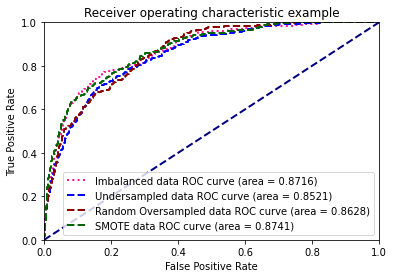

In [52]:
plt.figure()
lw = 2
plt.plot(fpr_imb, tpr_imb,
         label='Imbalanced data ROC curve (area = {0:0.4f})'
               ''.format(roc_auc_imb),
         color='deeppink', linestyle=':', linewidth=2)

plt.plot(fpr_us, tpr_us,
         label='Undersampled data ROC curve (area = {0:0.4f})'
               ''.format(roc_auc_us),
         color='blue', linestyle='--', linewidth=2)

plt.plot(fpr_os, tpr_os,
         label='Random Oversampled data ROC curve (area = {0:0.4f})'
               ''.format(roc_auc_os),
         color='darkred', linestyle='--', linewidth=2)

plt.plot(fpr_smote, tpr_smote,
         label='SMOTE data ROC curve (area = {0:0.4f})'
               ''.format(roc_auc_smote),
         color='darkgreen', linestyle='--', linewidth=2)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.00])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

 ### SVM
Support Vector Machine is employed for SMOTE data using two kernels: linear and guassian. Gaussian kernel performs the best in terms of both precision and recall.

In [53]:
sm = SMOTE(random_state=0)
X_SMOTE, y_SMOTE = sm.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_SMOTE, y_SMOTE, test_size=0.1)
svm = SVC(kernel='linear')
model = svm.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_test = label_binarize(y_test,classes=['no','yes'])
y_pred = label_binarize(y_pred,classes=['no','yes'])
print("Linear kernel- ","Precision: ",round(precision_score(y_test,y_pred),2),"Recall: ",round(recall_score(y_test,y_pred),2))
fpr_linear, tpr_linear, _ = roc_curve(y_test, y_pred)
roc_auc_linear = auc(fpr_linear, tpr_linear)
sm = SMOTE(random_state=0)
X_SMOTE, y_SMOTE = sm.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_SMOTE, y_SMOTE, test_size=0.1)
svm = SVC(kernel='rbf')
model = svm.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_test = label_binarize(y_test,classes=['no','yes'])
y_pred = label_binarize(y_pred,classes=['no','yes'])
print("Guassian kernel- ","Precision: ",round(precision_score(y_test,y_pred),2),"Recall: ",round(recall_score(y_test,y_pred),2))
fpr_rbf, tpr_rbf, _ = roc_curve(y_test, y_pred)
roc_auc_rbf = auc(fpr_rbf, tpr_rbf)

Linear kernel-  Precision:  0.96 Recall:  0.77
Guassian kernel-  Precision:  0.74 Recall:  0.76


ROC curves for two different kernels.



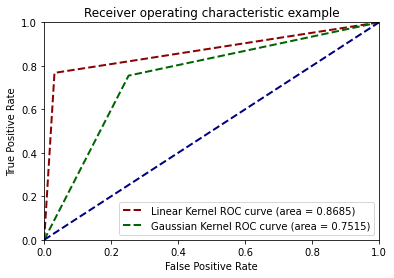

In [54]:
plt.figure()
lw = 2

plt.plot(fpr_linear, tpr_linear,
         label='Linear Kernel ROC curve (area = {0:0.4f})'
               ''.format(roc_auc_linear),
         color='darkred', linestyle='--', linewidth=2)

plt.plot(fpr_rbf, tpr_rbf,
         label='Gaussian Kernel ROC curve (area = {0:0.4f})'
               ''.format(roc_auc_rbf),
         color='darkgreen', linestyle='--', linewidth=2)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.00])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [55]:
#resampling the data

In [56]:
#spliting data to train and test with ratio of 90 to 10
from sklearn.model_selection import train_test_split
features = ['age', 'education', 'default', 'housing', 'loan', 'contact', 'duration',
       'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed','job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'marital_married', 'marital_single', 'month_aug',
       'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may',
       'month_nov', 'month_oct', 'month_sep', 'day_of_week_mon',
       'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed',
       'poutcome_nonexistent', 'poutcome_success']

X = data_bank[features]
y = data_bank[['y']]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1, random_state=0)

In [57]:
from sklearn.preprocessing import MinMaxScaler
# define min max scaler
scaler = MinMaxScaler()
# transform data
columns_to_scale= ['age','campaign','cons.conf.idx','cons.price.idx','duration','emp.var.rate','euribor3m','nr.employed',
                   'pdays','previous']
X[columns_to_scale]  = scaler.fit_transform(X[columns_to_scale])

/home/samuel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/samuel/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [58]:
X[columns_to_scale].head()

,age,campaign,cons.conf.idx,cons.price.idx,duration,emp.var.rate,euribor3m,nr.employed,pdays,previous
0,0.500000,0.0,0.60251,0.698753,0.404651,0.9375,0.957379,0.859735,1.0,0.0
2,0.256410,0.0,0.60251,0.698753,0.350388,0.9375,0.957379,0.859735,1.0,0.0
3,0.294872,0.0,0.60251,0.698753,0.234109,0.9375,0.957379,0.859735,1.0,0.0
4,0.500000,0.0,0.60251,0.698753,0.475969,0.9375,0.957379,0.859735,1.0,0.0
6,0.538462,0.0,0.60251,0.698753,0.215504,0.9375,0.957379,0.859735,1.0,0.0



#### Rescaling all numerical columns

In [59]:
from sklearn.preprocessing import MinMaxScaler
# define min max scaler
scaler = MinMaxScaler()
# transform data
columns_to_scale= ['age','campaign','cons.conf.idx','cons.price.idx','duration',
                   'emp.var.rate','euribor3m','nr.employed',
                   'pdays','previous']
X_train[columns_to_scale]  = scaler.fit_transform(X_train[columns_to_scale])
X_test[columns_to_scale]  = scaler.fit_transform(X_test[columns_to_scale])


/home/samuel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/samuel/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/home/samuel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

### applying Pca()

In [60]:
#PCA() 
from sklearn.decomposition import PCA
# Make an instance of the Model
pca = PCA()

In [61]:
pca.fit(X_train)

PCA()

In [62]:
pca.explained_variance_ratio_

array([3.97034237e-01, 8.11075418e-02, 6.29584174e-02, 5.22796467e-02,
       3.91887764e-02, 3.32539377e-02, 3.26075732e-02, 3.15376055e-02,
       2.86470934e-02, 2.77300538e-02, 2.27104577e-02, 2.09392521e-02,
       1.95390528e-02, 1.93512609e-02, 1.78706673e-02, 1.26665304e-02,
       1.06293403e-02, 9.26590052e-03, 8.37148580e-03, 8.29510203e-03,
       7.31489625e-03, 6.53675978e-03, 6.01781486e-03, 5.83729028e-03,
       5.66039842e-03, 4.61003658e-03, 3.86442761e-03, 3.83074394e-03,
       3.65877991e-03, 3.14521047e-03, 3.05215551e-03, 2.57537096e-03,
       2.14834233e-03, 2.03729519e-03, 1.47270391e-03, 1.08301353e-03,
       5.83241674e-04, 3.17096021e-04, 1.36835453e-04, 8.66122342e-05,
       2.96406423e-05, 1.74018601e-05])

Text(0, 0.5, 'Cumulativie Explained Varaince')

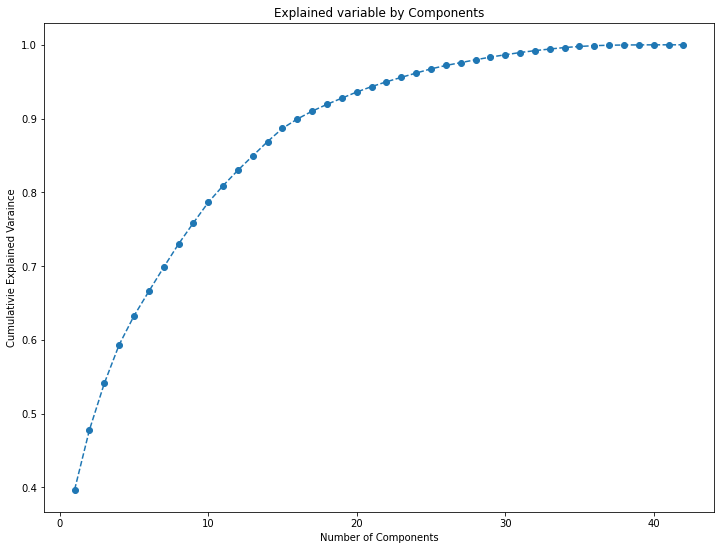

In [63]:
plt.figure(figsize=(12,9))
plt.plot(range(1,43),pca.explained_variance_ratio_.cumsum(), marker='o',linestyle='--')
plt.title("Explained variable by Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulativie Explained Varaince")

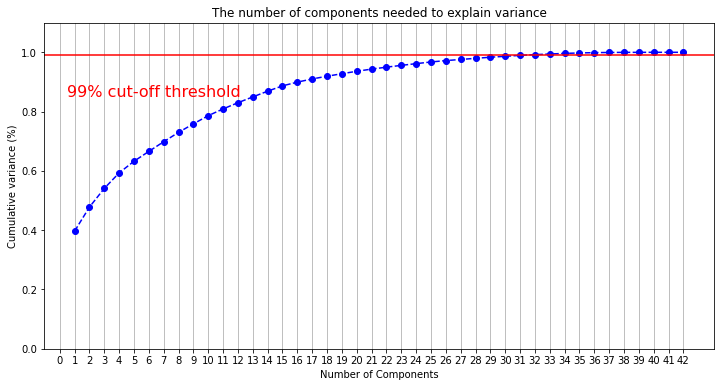

In [64]:
pca = PCA().fit(X_train)

# % matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 43, step=1)
yi = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, yi, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 43, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.99, color='r', linestyle='-')
plt.text(0.5, 0.85, '99% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [65]:
pca = PCA(0.99)  # project from 42 to 32 dimensions
projected = pca.fit_transform(X_train)
print(X_train.shape)
print(projected.shape)

(27439, 42)
(27439, 32)


In [68]:
X_train = pca.fit_transform(X_train)
X_test = pca.fit_transform(X_test)

In [69]:
## Logistic Regression model
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
# define the pipeline
steps = [('pca', PCA(n_components=25)), ('m', LogisticRegression())]
model = Pipeline(steps=steps)
# evaluate model
cv = StratifiedKFold(n_splits=10, random_state=45,shuffle=True)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
scores = ['accuracy','f1','precision','recall','roc_auc']
all_scores =cross_validate(model, X, y, scoring=scores, cv=cv, n_jobs=-1, error_score='raise') 
# report performance
print('Accuracy: %.3f ' % (np.mean(all_scores['test_accuracy'])))
print('F1 Score: %.3f ' % (np.mean(all_scores['test_f1'])))
print('Precision: %.3f ' % (np.mean(all_scores['test_precision'])))
print('Recall: %.3f ' % (np.mean(all_scores['test_recall'])))
print('ROC AUC score: %.3f ' % (np.mean(all_scores['test_roc_auc'])))

Accuracy: 0.893 
F1 Score: 0.426 
Precision: 0.660 
Recall: 0.315 
ROC AUC score: 0.861 


In [71]:
from sklearn.model_selection import KFold 
# define the pipeline
steps = [('pca', PCA(n_components=25)), ('m', LogisticRegression())]
model = Pipeline(steps=steps)
# evaluate model
cv = KFold(n_splits=10, random_state=45, shuffle=True)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
scores = ['accuracy','f1','precision','recall','roc_auc']
all_scores =cross_validate(model, X, y, scoring=scores, cv=cv, n_jobs=-1, error_score='raise') 
# report performance
print('Accuracy: %.3f ' % (np.mean(all_scores['test_accuracy'])))
print('F1 Score: %.3f ' % (np.mean(all_scores['test_f1'])))
print('Precision: %.3f ' % (np.mean(all_scores['test_precision'])))
print('Recall: %.3f ' % (np.mean(all_scores['test_recall'])))
print('ROC AUC score: %.3f ' % (np.mean(all_scores['test_roc_auc'])))

Accuracy: 0.893 
F1 Score: 0.427 
Precision: 0.660 
Recall: 0.316 
ROC AUC score: 0.861 


### XGBoost
##### Stratified KFold

In [72]:
from sklearn.model_selection import cross_val_score, cross_validate

from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
# define the pipeline
steps = [('pca', PCA(n_components=25)), ('m', XGBClassifier())]
model = Pipeline(steps=steps)
# evaluate model
cv = StratifiedKFold(n_splits=10, random_state=45, shuffle=True)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
scores = ['accuracy','f1','precision','recall','roc_auc']
all_scores =cross_validate(model, X, y, scoring=scores, cv=cv, n_jobs=-1, error_score='raise') 
# report performance
print('Accuracy: %.3f ' % (np.mean(all_scores['test_accuracy'])))
print('F1 Score: %.3f ' % (np.mean(all_scores['test_f1'])))
print('Precision: %.3f ' % (np.mean(all_scores['test_precision'])))
print('Recall: %.3f ' % (np.mean(all_scores['test_recall'])))
print('ROC AUC score: %.3f ' % (np.mean(all_scores['test_roc_auc'])))

Accuracy: 0.893 
F1 Score: 0.426 
Precision: 0.669 
Recall: 0.312 
ROC AUC score: 0.878 


In [74]:
# define the pipeline
steps = [('pca', PCA(n_components=25)), ('m', XGBClassifier())]
model = Pipeline(steps=steps)
# evaluate model
cv = KFold(n_splits=10, random_state=45, shuffle=True)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
scores = ['accuracy','f1','precision','recall','roc_auc']
all_scores =cross_validate(model, X, y, scoring=scores, cv=cv, n_jobs=-1, error_score='raise') 
# report performance
print('Accuracy: %.3f ' % (np.mean(all_scores['test_accuracy'])))
print('F1 Score: %.3f ' % (np.mean(all_scores['test_f1'])))
print('Precision: %.3f ' % (np.mean(all_scores['test_precision'])))
print('Recall: %.3f ' % (np.mean(all_scores['test_recall'])))
print('ROC AUC score: %.3f ' % (np.mean(all_scores['test_roc_auc'])))

Accuracy: 0.893 
F1 Score: 0.427 
Precision: 0.663 
Recall: 0.315 
ROC AUC score: 0.879 


## Multilayer perception

#### Stratified KFold

In [75]:
# defining the pipeline for multilayer perception model
steps = [('pca', PCA(n_components=30)), ('m', MLPClassifier(hidden_layer_sizes=(8,8,8), activation='relu',
                                                            solver='adam', max_iter=500))]
model = Pipeline(steps=steps)
# evaluate model
cv = StratifiedKFold(n_splits=10, random_state=45)
scores = ['accuracy','f1','precision','recall','roc_auc']
all_scores =cross_validate(model, X, y, scoring=scores, cv=cv, n_jobs=-1, error_score='raise') 
# report performance
print('Accuracy: %.3f ' % (np.mean(all_scores['test_accuracy'])))
print('F1 Score: %.3f ' % (np.mean(all_scores['test_f1'])))
print('Precision: %.3f ' % (np.mean(all_scores['test_precision'])))
print('Recall: %.3f ' % (np.mean(all_scores['test_recall'])))

Accuracy: 0.739 
F1 Score: 0.091 
Precision: 0.121 
Recall: 0.168 


#### using KFold


In [77]:
# define the pipeline
steps = [('pca', PCA(n_components=30)), ('m', MLPClassifier(hidden_layer_sizes=(8,8,8), activation='relu',
                                                            solver='adam', max_iter=500))]
model = Pipeline(steps=steps)
# evaluate model
cv = KFold(n_splits=10, random_state=45, shuffle=True)
scores = ['accuracy','f1','precision','recall','roc_auc']
all_scores =cross_validate(model, X, y, scoring=scores, cv=cv, n_jobs=-1, error_score='raise') 
# report performance
print('Accuracy: %.3f ' % (np.mean(all_scores['test_accuracy'])))
print('F1 Score: %.3f ' % (np.mean(all_scores['test_f1'])))
print('Precision: %.3f ' % (np.mean(all_scores['test_precision'])))
print('Recall: %.3f ' % (np.mean(all_scores['test_recall'])))
print('ROC AUC score: %.3f ' % (np.mean(all_scores['test_roc_auc'])))

Accuracy: 0.895 
F1 Score: 0.524 
Precision: 0.616 
Recall: 0.456 
ROC AUC score: 0.921 


### Conclusion
For the given data, visualization of data, ways to treat imbalance in the data and best predictive model to determine the term deposit subscription was explored. From visualization, it can be derived that repeated campaign calls to customers within 20 days of previous call increases the subscription. After treating the imbalance in data using SMOTE, SVM with Gaussian kernel performs the best in terms of precision and recall.